phrase fit:
fit phrase model to review and summary texts

word embedding fit:
fit word embedding model to words/phrases in review text so that words have meaning

simplify vocabulary:
identify FqW most frequent words/phrases in summary texts
map every word to it's nearest neighbor among most frequent words/phrases

create document vectors based on reduced vocab summary texts

todo: find a way to add context

In [ ]:
%load_ext autoreload
%autoreload 2
import time
start_time = time.time()

import json

import numpy as np

import sys
sys.path.append("../libraries/")
from selector import split_data
from semanticClassifiers import bigramsPhraser, docTopTransformer2

In [2]:
# Read in testing data for 80/20 split
# we won't use val_dat at all
json_dat, val_dat = split_data('../data/Sports_and_Outdoors_Reviews_training.json', 80)
json_dat = json_dat[0:141792]
del val_dat

In [3]:
# create lists with one review per elem
summary = []
review = []
rating = []
prod_id = []
for i in range(0,len(json_dat)):
    if json_dat[i].get('reviewText') and json_dat[i].get('summary'): #not all reviews have text
        rating.append(json_dat[i].get('overall'))
        summary.append(json_dat[i].get('summary'))
        review.append(json_dat[i].get('reviewText'))
        prod_id.append(json_dat[i].get('asin'))
        
del json_dat

In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from spellchecker import SpellChecker


def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [this_tok for this_tok in tokens if not this_tok in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(this_tok) for this_tok in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

def preprocess_data2(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # create spell checker
    sp = SpellChecker()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # correct spelling
        tokens = [sp.correction(this_tok) for this_tok in tokens]
        # remove stop words from tokens
        stopped_tokens = [this_tok for this_tok in tokens if not this_tok in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(this_tok) for this_tok in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [ ]:
# the get_wordnet_pos() function relies on a neural method, 
# and preprocess_data_lemmatize therefore does too. Implemented
# here for some benchmarking only

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def preprocess_data_lemmatize(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create lemmatizer class
    wordnet_lemmatizer = WordNetLemmatizer()    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [this_tok for this_tok in tokens if not this_tok in en_stop]
        # stem tokens
        lemmatized_tokens = [wordnet_lemmatizer.lemmatize(this_tok, pos=get_wordnet_pos(this_tok))
                             for this_tok in stopped_tokens]
        # add tokens to list
        texts.append(lemmatized_tokens)
    return texts

In [5]:
awesome = np.array(rating) >= 4.5
stem_summary_text=preprocess_data(summary)
stem_summary_text2=preprocess_data2(summary)
#del summary
#del review

In [11]:
# fit some example models to see what's being misclassified or correctly classified

from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

idx = np.random.permutation([x for x in range(0, len(awesome))])
sample_idx = idx[0:np.power(2,14)]

train_lbls = awesome[sample_idx]
this_prod_id = [prod_id[i] for i in sample_idx]
stem_train_text = [stem_summary_text[i] for i in sample_idx]
stem_train_text2 = [stem_summary_text2[i] for i in sample_idx]
        
gkf = GroupKFold(n_splits=5)
cv = gkf.split(stem_train_text, train_lbls, groups=this_prod_id)

doc2Top = docTopTransformer2(d=300, distributed=False)
clf = LinearSVC()

estimators = [('latentSemProj', doc2Top), ('clf', clf)]
semClf = Pipeline(estimators)

predict = cross_val_predict(semClf, stem_train_text, train_lbls, cv=cv)


gkf = GroupKFold(n_splits=5)
cv = gkf.split(stem_train_text2, train_lbls, groups=this_prod_id)

doc2bigram = bigramsPhraser()
doc2Top = docTopTransformer2(d=300, distributed=False)
clf = LinearSVC()

estimators = [('bigram',doc2bigram), ('latentSemProj', doc2Top), ('clf', clf)]
semClf = Pipeline(estimators)

predict2 = cross_val_predict(semClf, stem_train_text2, train_lbls, cv=cv)

In [6]:
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

import time

# get performance estimates for n_models using k-fold cross validation
k = 5
n_models = 3

old_sample_idx = []
sample_idx = []
nn = []
sample_idx = []
review_acc2 = []
review_t2 = []
review_acc1 = []
review_t1 = []

review_cv_fold_scores1=[]
review_cv_fold_scores2=[]
for rep in range(0,7):
    # generate random nonoverlapping samples of different numbers of elements
    # sample lengths will be log distributed
    # sample_idx will be an array of arrays, with each array containing
    # the indices of a set. Smaller sets will be earlier in the stack, so
    # sample_idx[0] is the smallest and sample_idx[-1] is the largest
    if sample_idx:
        old_sample_idx = np.hstack(np.hstack([old_sample_idx, sample_idx]))

    n = [np.int(x) for x in np.logspace(8, 14, num=n_models, base=2)]
    cum_n = []
    for x in n:
        cum_n.append(np.int(np.sum(cum_n[-1:]) + x))

    idx = np.random.permutation([x for x in range(0, len(awesome)) if x not in old_sample_idx])

    sample_idx = [idx[range(0,cum_n[0])]]
    
    for i in range(1, len(n)):
        this_sample_idx = idx[range(cum_n[i-1], cum_n[i])]

        for j in range(1,i-1):
            assert all([a not in this_sample_idx for a in sample_idx[j]])
        assert all([a not in this_sample_idx for a in old_sample_idx])

        sample_idx.append(this_sample_idx)

    # fit models for sets selected above
    this_n = []
    this_review_acc1 = []
    this_review_t1 = []
    this_review_acc2 = []
    this_review_t2 = []
    for i in range(0,n_models):
        # these will be the same for both review and summary text
        train_lbls = awesome[sample_idx[i]]
        this_prod_id = [prod_id[i] for i in sample_idx[i]]
        
        # size of a training set during cross validation
        this_n.append(len(train_lbls)*(k-1.0)/k)
        
        #################################
        ### review text specific code ###        
        #################################
        train_text = [stem_summary_text[i] for i in sample_idx[i]]
        
        gkf = GroupKFold(n_splits=5)
        cv = gkf.split(train_text, train_lbls, groups=this_prod_id)

        doc2Top = docTopTransformer2(d=300, distributed=False)
        clf = LinearSVC()

        estimators = [('latentSemProj', doc2Top), ('clf', clf)]
        semClf = Pipeline(estimators)

        try:
            # cross validate over the pipeline using group k-fold CV
            t0 = time.time()
            this_score = cross_val_score(semClf, train_text, train_lbls, cv=cv)
            t1 = time.time()

            this_review_acc1.append(np.mean(this_score))
            this_review_t1.append(t1 - t0)
            
            # we'll save an instance of these scores to illustrate
            # some statistical features below
            if rep==0:
                review_cv_fold_scores1.append(this_score)
        except:
            print('error on model ' + str(i) + ' of rep ' + str(rep))
            
            this_review_acc1.append([])
            this_review_t1.append([])
            if rep==0:
                review_cv_fold_scores1.append([])
            
        #################################
        ### sumary text specific code ###
        #################################
        train_text = [stem_summary_text2[i] for i in sample_idx[i]]

        gkf = GroupKFold(n_splits=5)
        cv = gkf.split(train_text, train_lbls, groups=this_prod_id)
        
        doc2bigram = bigramsPhraser()
        doc2Top = docTopTransformer2(d=300, distributed=False)
        clf = LinearSVC()

        estimators = [('latentSemProj', doc2Top), ('clf', clf)]
        semClf = Pipeline(estimators)
        
        try:
            # cross validate over the pipeline using group k-fold CV
            t0 = time.time()
            this_score = cross_val_score(semClf, train_text, train_lbls, cv=cv)
            t1 = time.time()

            this_review_acc2.append(np.mean(this_score))
            this_review_t2.append(t1 - t0)
            
            # we'll save an instance of these scores to illustrate
            # some statistical features below
            if rep==0:
                review_cv_fold_scores2.append(this_score)
        except:
            print('error on model ' + str(i) + ' of rep ' + str(rep))
            
            this_review_acc2.append([])
            this_review_t2.append([])
            if rep==0:
                review_cv_fold_scores2.append([])
        
    # this assumes at least one model successfully evaluated above. It's a safe assumption
    review_acc1.append(this_review_acc1)
    review_acc2.append(this_review_acc2)
    nn.append(this_n)
    review_t1.append(this_review_t1)
    review_t2.append(this_review_t2)

/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested s

In [ ]:
# do some cleanup
import copy
review_acc1_bak = copy.deepcopy(review_acc1)
review_t1_bak = copy.deepcopy(review_t1)
review_acc2_bak = copy.deepcopy(review_acc2)
review_t2_bak = copy.deepcopy(review_t2)

In [ ]:
# do some cleanup, manually code this to handle errors from above
import copy
#review_acc_bak = copy.deepcopy(review_acc)
#review_t_bak = copy.deepcopy(review_t)
#summary_acc_bak = copy.deepcopy(summary_acc)
#summary_t_bak = copy.deepcopy(summary_t)
review_acc1 = copy.deepcopy(review_acc1_bak)
review_t1 = copy.deepcopy(review_t1_bak)
review_acc2 = copy.deepcopy(review_acc2_bak)
review_t2 = copy.deepcopy(review_t2_bak)

# replace two missing values with the mean of the others
review_acc2[2][1] = np.mean([x for x in review_acc2[2][:] if x])
review_t2[2][1] = np.mean([x for x in review_t2[2][:] if x])

review_acc2[5][1] = np.mean([x for x in review_acc2[5][:] if x])
review_t2[5][1] = np.mean([x for x in review_t2[5][:] if x])

The next plot shows the estimated model performance obtained when using a CV estimator on independent datasets. Each box and whisker represents the estimates obtained from 7 independent datasets. Purple represents estimates of models trained on review text, red represents estimates of models trained on summary text. Other than the input features the models are the same. Different amounts of training data are also considered, and as you can see there is a dependence between amount of training data and model performance. 

Here an important comment can be made. Cross validation is the best *minimally biased* estimator we have of a model performance. We can fit a model to any dataset we have access to, but CV tells us how well we can expect that model to perform, hence it's an estimate of model performance. However this estimate is obtained by training on SUBSETS of our data, not the full dataset. In the case of 5-fold cross validation we train on 4/5ths of our data on each CV fold. As you can see from the plots below the more data we have the better our model performance, so if we're training on less than the full dataset with CV then CV will somewhat underestimate the performance of our true model obtained when fitting to the full dataset. This is what's meant by minimally biased. 

The sample sizes used here are 256, 512, 1024, etc (increasing powers of 2), however rather than plotting these on the x-axis I've instead plotted 4/5 of these numbers, since this is the sample size for which our estimates can be assumed to be unbiased.

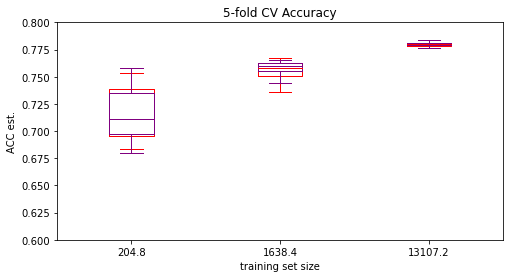

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
m_acc = np.matrix(review_acc1)
'''
mu_acc = np.array(np.mean(m_acc, axis=0))
s_acc = np.array(np.std(m_acc, ddof=1, axis=0)/np.sqrt(7))

x = np.transpose(np.array([x for x in range(1,11)]))
plt.bar(x,mu_acc[0],yerr=s_acc[0]);
'''
c1 = "red"
box1 = plt.boxplot(m_acc)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c1)
plt.setp(box1["fliers"], markeredgecolor=c1)


m_acc = np.matrix(review_acc2)

c2 = "purple"
box2 = plt.boxplot(m_acc)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box2[item], color=c2)
plt.setp(box2["fliers"], markeredgecolor=c2)

plt.xticks(range(1,n_models+1),labels=nn[1])

plt.xlabel('training set size');
plt.ylabel('ACC est.');
plt.ylim([0.6,0.8]);
plt.title('5-fold CV Accuracy');

The figures below show the same data with the x-axis scaled in two different ways for legibility. What they show are relative compute times. For these algorithms and feature sets (semantic models of summary or review texts), we're not data limited, we're limited by compute time. Say we're only willing to run our algorithms for an hour to obtain a best fit, which algorithm should we pick? At fixed amounts of data the summary text outperforms the review text, but if better performance can be obtained in the same time using review text with more data, then it doesn't matter. The plots below show that summary text both performs better than review text and does so in less time.

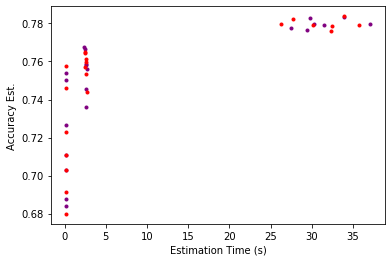

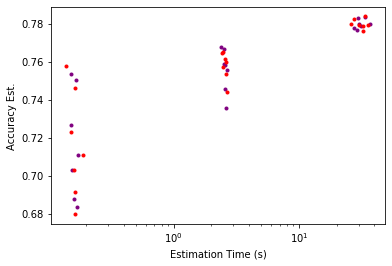

In [8]:
r_acc = [np.array(r) for r in review_acc1]
r_t = [np.array(t) for t in review_t1];

s_acc = [np.array(r) for r in review_acc2]
s_t = [np.array(t) for t in review_t2];

plt.plot(r_t,r_acc,'.',color="purple");
plt.plot(s_t,s_acc,'.',color="red");
plt.xlabel('Estimation Time (s)')
plt.ylabel('Accuracy Est.');

plt.figure()

plt.plot(r_t,r_acc,'.',color="purple");
plt.plot(s_t,s_acc,'.',color="red");
plt.xlabel('Estimation Time (s)')
plt.ylabel('Accuracy Est.');
plt.xscale('log')

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree

import pickle
with open('pos_tagger.clf',mode='rb') as f:
    pos_clf = pickle.load(f)

with open('pos_tagger.vec',mode='rb') as f:
    vec = pickle.load(f)

In [32]:
def fw_extract_features(tagged_sentence, index):
    token, tag = tagged_sentence[index]
    prev_token = ""
    prev_tag = ""
    if index > 0:
        prev_token, prev_tag = tagged_sentence[index - 1]
            
    is_number = False
    try:
        if float(token):
            is_number = True
    except:
        pass
    features_dict = {"token": token
        , "lower_cased_token": token.lower()
        , "prev_token": prev_token
        , "prev_tag": prev_tag
        , "suffix1": token[-1]
        , "suffix2": token[-2:]
        , "suffix3": token[-3:]
        , "is_capitalized": token.upper() == token
        , "is_number": is_number}
    return features_dict

In [42]:
tokenizer = RegexpTokenizer(r'\w+')

tok = tokenizer.tokenize(review[1])
null_tag = [(this_tok, 'NULL') for this_tok in tok]

feat = [fw_extract_features(null_tag, i) for i in range(len(null_tag))]
feat = vec.transform(feat)
[(tok[i], pos) for i, pos in enumerate(pos_clf.predict(feat))]

[('A', 'DT'),
 ('great', 'JJ'),
 ('replacement', 'NN'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('junk', 'NN'),
 ('plastic', 'JJ'),
 ('caps', 'RB'),
 ('that', 'IN'),
 ('came', 'NN'),
 ('with', 'IN'),
 ('my', 'PRP$'),
 ('presta', 'NNP'),
 ('tubes', 'NNS'),
 ('The', 'DT'),
 ('plastic', 'JJ'),
 ('caps', 'RB'),
 ('stripped', 'VBD'),
 ('and', 'CC'),
 ('broke', 'VB'),
 ('making', 'VBG'),
 ('them', 'PRP'),
 ('useless', 'NN')]